## **Advanced EDA**

## **Data Preparation**
- For machine learning purposes data preparation I combined the tables my team would be using for the project, listed below:
- Vehicle related data:
  1. safe_driving
  2. breda_road
- And weather data:
  3. precipitation
  4. greenery

In [25]:
import psycopg2
import psycopg2.extras
import pandas as pd
from psycopg2.extras import execute_values

# Database connection parameters
db_params = {
    'host': '194.171.191.226',
    'port': '6379',
    'database': 'postgres',
    'user': 'group24',
    'password': 'blockd_2024group24_77'
}

# Establish a connection to the database
try:
    conn = psycopg2.connect(
        host=db_params['host'],
        port=db_params['port'],
        database=db_params['database'],
        user=db_params['user'],
        password=db_params['password']
    )
    print("Connection to the database established successfully.")
except Exception as e:
    print(f"Error connecting to the database: {e}")
    conn = None

# Use the connection (example of a query)
if conn is not None:
    try:
        # Create a cursor object using the connection
        cursor = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)

        # Example query
        query = "SELECT * FROM group24_warehouse.normalised LIMIT 5;"

        # Execute the query
        cursor.execute(query)

        # Fetch the results
        results = cursor.fetchall()

        # Convert the results to a pandas DataFrame
        df = pd.DataFrame(results)

        # Print the DataFrame
        print(df)

        # Close the cursor
        cursor.close()
    except Exception as e:
        print(f"Error executing query: {e}")
    finally:
        # Close the connection
        conn.close()
        print("Database connection closed.")


Connection to the database established successfully.
         0                       1                       2         3   \
0  30168507 2021-09-06 10:49:37.000 2021-09-06 10:49:43.000 -0.063058   
1  30168508 2023-03-24 07:48:59.700 2023-03-24 07:49:00.800 -0.747171   
2  30168509 2022-03-31 09:20:26.000 2022-03-31 09:20:37.000  0.635016   
3  30168510 2022-10-18 15:53:15.000 2022-10-18 15:53:25.000  0.495401   
4  30168511 2022-07-17 19:57:57.500 2022-07-17 19:58:16.500  1.751935   

         4         5         6         7         8                9   ...  \
0  0.615587  0.675769  0.704716  0.718507  1.076366            SPEED  ...   
1  0.830240  0.504512  0.143285  0.224490 -0.002986  HARSH CORNERING  ...   
2  0.713007  0.653869  0.687627  0.759731  1.035300            SPEED  ...   
3  0.741048  0.660359  0.710019  0.734694  1.046488            SPEED  ...   
4  0.595511  0.622915  0.710019  0.836735  1.095837            SPEED  ...   

    27  28  29  30  31          32   33  34  

### **Connecting to the Database**
- Whenever working in this notebook, make sure to always run the codeblock below to have the right credentials to connect to the database!

In [26]:
import psycopg2
import psycopg2.extras
import pandas as pd
from psycopg2.extras import execute_values

# Database connection parameters
db_params = {
    'host': '194.171.191.226',
    'port': '6379',
    'database': 'postgres',
    'user': 'group24',
    'password': 'blockd_2024group24_77'
}

#### **Displaying all the tables in group24_warehouse**

In [27]:
import psycopg2

# Function to fetch table names from the specified schema
def fetch_table_names(schema_name, db_params):
    try:
        # Establish a connection to the database
        connection = psycopg2.connect(**db_params)
        cursor = connection.cursor()

        # SQL query to fetch table names from the specified schema
        fetch_tables_query = f"""
        SELECT table_name 
        FROM information_schema.tables 
        WHERE table_schema = '{schema_name}';
        """

        # Execute the query
        cursor.execute(fetch_tables_query)
        # Fetch all results
        tables = cursor.fetchall()

        # Print table names
        print(f"Tables in schema '{schema_name}':")
        for table in tables:
            print(table[0])

    except Exception as e:
        print("An error occurred while fetching table names:", e)
    
    finally:
        if connection:
            cursor.close()
            connection.close()

# Fetch and print table names from the group24_warehouse schema
fetch_table_names('group24_warehouse', db_params)


Tables in schema 'group24_warehouse':
safe_driving
breda_road
precipitation
temperature
greenery
pre_normalised
normalised
view_normalised


#### **Dropping the tables**

In [4]:
import psycopg2

# Define the table names in the group24_warehouse schema
table_names = [
   "pre_normalised",
    "normalised",
    "view_normalised",
    "safe_driving",
    "breda_road",
    "precipitation",
    "temperature",
    "greenery",
]

# SQL query to drop a table
drop_table_query = "DROP TABLE IF EXISTS group24_warehouse.{} CASCADE;"

# Function to drop tables
def drop_tables(table_names, db_params):
    try:
        connection = psycopg2.connect(**db_params)
        cursor = connection.cursor()
        
        for table in table_names:
            cursor.execute(drop_table_query.format(table))
            print(f"Table '{table}' dropped successfully.")
        
        connection.commit()
    except Exception as e:
        print(f"An error occurred while dropping tables: {e}")
        if connection:
            connection.rollback()
    finally:
        if connection:
            cursor.close()
            connection.close()
            print("Database connection closed.")
# Drop the tables
drop_tables(table_names, db_params)


Table 'pre_normalised' dropped successfully.
Table 'normalised' dropped successfully.
Table 'view_normalised' dropped successfully.
Table 'safe_driving' dropped successfully.
Table 'breda_road' dropped successfully.
Table 'precipitation' dropped successfully.
Table 'temperature' dropped successfully.
Table 'greenery' dropped successfully.
Database connection closed.


#### **Creating, preprocessing and Inserting data into the Normalised Tables**

#### **Cleansing the data in the dataframes**

In [5]:
import pandas as pd
import psycopg2
from sklearn.impute import SimpleImputer
# Define the columns and their data types for each table
columns_info = {
    "safe_driving": [
        ('eventid', 'INTEGER'),
        ('event_start', 'TIMESTAMP'),
        ('event_end', 'TIMESTAMP'),
        ('duration_seconds', 'REAL'),
        ('latitude', 'REAL'),
        ('longitude', 'REAL'),
        ('speed_kmh', 'REAL'),
        ('end_speed_kmh', 'REAL'),
        ('maxwaarde', 'REAL'),
        ('category', 'VARCHAR'),
        ('incident_severity', 'VARCHAR'),
        ('is_valid', 'BOOLEAN'),
        ('road_segment_id', 'INTEGER'),
        ('road_manager_type', 'VARCHAR'),
        ('road_number', 'VARCHAR'),
        ('road_name', 'VARCHAR'),
        ('place_name', 'VARCHAR'),
        ('municipality_name', 'VARCHAR'),
        ('road_manager_name', 'VARCHAR')
    ],
    "breda_road": [
        ('_id', 'BIGINT'),
        ('objectbegintijd', 'TIMESTAMP'),
        ('objecteindtijd', 'TIMESTAMP'),
        ('bgt_status', 'VARCHAR'),
        ('plus_status', 'VARCHAR'),
        ('bgt_functie', 'VARCHAR'),
        ('plus_functie', 'VARCHAR'),
        ('bgt_fysiekvoorkomen', 'VARCHAR'),
        ('plus_fysiekvoorkomen', 'VARCHAR'),
        ('wegdeeloptalud', 'BIGINT'),
        ('relatievehoogteligging', 'BIGINT')
    ],
    "precipitation": [
        ('dtg', 'TIMESTAMP'),
        ('latitude', 'REAL'),
        ('longitude', 'REAL'),
        ('altitude', 'REAL'),
        ('dr_pws_10', 'REAL'),
        ('dr_regenm_10', 'REAL'),
        ('ww_cor_10', 'REAL'),
        ('ri_pws_10', 'REAL'),
        ('ri_regenm_10', 'REAL')
    ],
    "temperature": [
        ('dtg', 'TIMESTAMP'),
        ('latitude', 'REAL'),
        ('longitude', 'REAL'),
        ('altitude', 'REAL'),
        ('t_dryb_10', 'REAL'),
        ('tn_10cm_past_6h_10', 'REAL'),
        ('t_dewp_10', 'REAL'),
        ('t_wetb_10', 'REAL')
    ],
    "greenery": [
        ('_id', 'BIGINT'),
        ('_key', 'VARCHAR'),
        ('namespace', 'VARCHAR'),
        ('lokaalid', 'VARCHAR'),
        ('objectbegintijd', 'TIMESTAMP'),
        ('objecteindtijd', 'TIMESTAMP'),
        ('tijdstipregistratie', 'TIMESTAMP'),
        ('eindregistratie', 'TIMESTAMP'),
        ('lv_publicatiedatum', 'TIMESTAMP'),
        ('bronhouder', 'VARCHAR'),
        ('inonderzoek', 'BIGINT'),
        ('relatievehoogteligging', 'BIGINT'),
        ('bgt_status', 'VARCHAR'),
        ('plus_status', 'VARCHAR'),
        ('bgt_type', 'VARCHAR'),
        ('plus_type', 'VARCHAR')
    ]
}
# Define default timestamp for missing datetime values
default_timestamp = pd.Timestamp('1970-01-01', tz='UTC')
# Queries to read tables
safe_driving_query = """
SELECT DISTINCT eventid, event_start, event_end, duration_seconds, latitude, longitude, speed_kmh, end_speed_kmh,
       maxwaarde, category, incident_severity, is_valid, road_segment_id, road_manager_type, road_number, 
       road_name, place_name, municipality_name, road_manager_name 
FROM data_lake.safe_driving
WHERE is_valid = True;
"""
breda_road_query = """
SELECT DISTINCT _id, objectbegintijd, objecteindtijd, bgt_status, plus_status, bgt_functie, plus_functie,
       bgt_fysiekvoorkomen, plus_fysiekvoorkomen, wegdeeloptalud, relatievehoogteligging 
FROM data_lake.breda_road;
"""
precipitation_query = """
SELECT DISTINCT dtg, latitude, longitude, altitude, dr_pws_10, dr_regenm_10, ww_cor_10, ri_pws_10, ri_regenm_10 
FROM data_lake.precipitation;
"""
temperature_query = """
SELECT DISTINCT dtg, latitude, longitude, altitude, t_dryb_10, tn_10cm_past_6h_10, t_dewp_10, t_wetb_10 
FROM data_lake.temperature;
"""
greenery_query = """
SELECT DISTINCT _id, _key, namespace, lokaalid, objectbegintijd, objecteindtijd, tijdstipregistratie, eindregistratie,
       lv_publicatiedatum, bronhouder, inonderzoek, relatievehoogteligging, bgt_status, plus_status, bgt_type, plus_type 
FROM data_lake.greenery;
"""

# Function to read table into DataFrame
def read_table(query, conn):
    cursor = conn.cursor()
    cursor.execute(query)
    colnames = [desc[0] for desc in cursor.description]
    rows = cursor.fetchall()
    cursor.close()
    return pd.DataFrame(rows, columns=colnames)
def clean_dataframe(df, unique_id_col, lat_col, lon_col, event_start_col, event_end_col):
    # Create a copy to avoid modifying views accidentally
    df = df.copy()
    # Convert event start and end columns to datetime safely
    df[event_start_col] = pd.to_datetime(df[event_start_col], errors='coerce', utc=True)
    df[event_end_col] = pd.to_datetime(df[event_end_col], errors='coerce', utc=True)
    if df[event_start_col].dt.tz is not None:
        df[event_start_col] = df[event_start_col].dt.tz_localize(None)
    if df[event_end_col].dt.tz is not None:
        df[event_end_col] = df[event_end_col].dt.tz_localize(None)
# Add time of day feature
    def time_of_day(hour):
        if 5 <= hour < 12:
            return 'Morning'
        elif 12 <= hour < 17:
            return 'Afternoon'
        elif 17 <= hour < 21:
            return 'Evening'
        else:
            return 'Night'
    # Add time of day feature
    if pd.api.types.is_datetime64_any_dtype(df[event_start_col]):
        df.loc[:, 'time_of_day'] = df[event_start_col].dt.hour.apply(time_of_day)
        
    # Calculate distance to a landmark
    landmark_latitude = 51.5890
    landmark_longitude = 4.7745
    df.loc[:, 'distance_to_landmark'] = ((df[lat_col] - landmark_latitude)**2 + (df[lon_col] - landmark_longitude)**2)**0.5
    
    # Calculate event duration if both columns are datetime
    if pd.api.types.is_datetime64_any_dtype(df[event_start_col]) and pd.api.types.is_datetime64_any_dtype(df[event_end_col]):
        df.loc[:, 'event_duration'] = (df[event_end_col] - df[event_start_col]).dt.total_seconds
        
    return df
    
# Connect to the database and read the tables into DataFrames
try:
    connection = psycopg2.connect(**db_params)
    safe_driving_df = read_table(safe_driving_query, connection)
    breda_road_df = read_table(breda_road_query, connection)
    precipitation_df = read_table(precipitation_query, connection)
    temperature_df = read_table(temperature_query, connection)
    greenery_df = read_table(greenery_query, connection)
except Exception as e:
    print(f"An error occurred while reading tables: {e}")
finally:
    if connection:
        connection.close
        
# Clean and preprocess each dataframe
safe_driving_df = clean_dataframe(safe_driving_df, 'eventid', 'latitude', 'longitude', 'event_start', 'event_end')
breda_road_df['latitude'] = 0.0
breda_road_df['longitude'] = 0.0
breda_road_df = clean_dataframe(breda_road_df, '_id', 'latitude', 'longitude', 'objectbegintijd', 'objecteindtijd')
breda_road_df = breda_road_df.drop(columns=['latitude', 'longitude'])
precipitation_df = clean_dataframe(precipitation_df, 'dtg', 'latitude', 'longitude', 'dtg', 'dtg')
temperature_df = clean_dataframe(temperature_df, 'dtg', 'latitude', 'longitude', 'dtg', 'dtg')
greenery_df['latitude'] = 0.0
greenery_df['longitude'] = 0.0
greenery_df = clean_dataframe(greenery_df, '_id', 'latitude', 'longitude', 'objectbegintijd', 'objecteindtijd')
greenery_df = greenery_df.drop(columns=['latitude', 'longitude'])

# Function to preprocess the DataFrame
def preprocess_dataframe(df, columns_info):
    datetime_columns = [col for col, dtype in columns_info if dtype == 'TIMESTAMP']
    for col in datetime_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce', utc=True).dt.tz_localize(None)
        df[col] = df[col].fillna(default_timestamp)

    for col, dtype in columns_info:
        if dtype in ['REAL', 'INTEGER', 'BIGINT']:
            df[col] = df[col].fillna(0)
        else:
            df[col] = df[col].fillna('')
    df = df[[col for col, _ in columns_info]].copy()
    return df

# Preprocess and impute each DataFrame
safe_driving_df = preprocess_dataframe(safe_driving_df, columns_info["safe_driving"])

breda_road_df = preprocess_dataframe(breda_road_df, columns_info["breda_road"])

precipitation_df = preprocess_dataframe(precipitation_df, columns_info["precipitation"])

temperature_df = preprocess_dataframe(temperature_df, columns_info["temperature"])

greenery_df = preprocess_dataframe(greenery_df, columns_info["greenery"])

# Ensure all values in maxwaarde are positive
safe_driving_df['maxwaarde'] = safe_driving_df['maxwaarde'].abs()

# Check for missing values
def check_missing_values(df, df_name):
    missing_values = df.isnull().sum()
    print(f"Missing values in {df_name} DataFrame:\n{missing_values}\n")

check_missing_values(safe_driving_df, 'safe_driving')
check_missing_values(breda_road_df, 'breda_road')
check_missing_values(precipitation_df, 'precipitation')
check_missing_values(temperature_df, 'temperature')
check_missing_values(greenery_df, 'greenery')


/tmp/ipykernel_707742/4036434537.py:184: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(default_timestamp)
/tmp/ipykernel_707742/4036434537.py:184: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(default_timestamp)
/tmp/ipykernel_707742/4036434537.py:184: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', 

Missing values in safe_driving DataFrame:
eventid              0
event_start          0
event_end            0
duration_seconds     0
latitude             0
longitude            0
speed_kmh            0
end_speed_kmh        0
maxwaarde            0
category             0
incident_severity    0
is_valid             0
road_segment_id      0
road_manager_type    0
road_number          0
road_name            0
place_name           0
municipality_name    0
road_manager_name    0
dtype: int64

Missing values in breda_road DataFrame:
_id                       0
objectbegintijd           0
objecteindtijd            0
bgt_status                0
plus_status               0
bgt_functie               0
plus_functie              0
bgt_fysiekvoorkomen       0
plus_fysiekvoorkomen      0
wegdeeloptalud            0
relatievehoogteligging    0
dtype: int64

Missing values in precipitation DataFrame:
dtg             0
latitude        0
longitude       0
altitude        0
dr_pws_10       0
dr_regenm_10

#### **Displaying time columns of each table**

In [6]:
# Function to print the first few rows of date columns

import pandas as pd
import psycopg2

# Assuming you already have a DataFrame named df loaded
# Function to identify and print date columns
def print_time_columns(df):
    # Identify date columns by checking the data type
    date_columns = [col for col in df.columns if pd.api.types.is_datetime64_any_dtype(df[col])]
    
    # Select and print the date columns from the DataFrame
    print(df[date_columns].head())  

# Example usage:

# Print time columns for each DataFrame
print_time_columns(safe_driving_df)
print_time_columns(breda_road_df)
print_time_columns(temperature_df,)
print_time_columns(precipitation_df)
print_time_columns(greenery_df)


              event_start               event_end
0 2023-08-08 10:12:31.000 2023-08-08 10:12:38.000
1 2023-08-08 12:30:49.000 2023-08-08 12:30:56.000
2 2023-08-07 06:43:15.000 2023-08-07 06:43:16.100
3 2023-08-07 15:40:14.900 2023-08-07 15:40:16.300
4 2023-08-30 10:02:58.100 2023-08-30 10:03:00.000
  objectbegintijd            objecteindtijd
0      2014-11-18 1970-01-01 00:00:00+00:00
1      2018-05-04 1970-01-01 00:00:00+00:00
2      2024-01-23 1970-01-01 00:00:00+00:00
3      2014-11-18 1970-01-01 00:00:00+00:00
4      2014-11-18 1970-01-01 00:00:00+00:00
                  dtg
0 2017-12-17 12:30:00
1 2017-08-13 23:20:00
2 2018-04-01 11:40:00
3 2017-05-24 15:00:00
4 2017-02-15 20:50:00
                  dtg
0 2020-03-22 02:30:00
1 2019-07-11 14:50:00
2 2019-08-18 13:30:00
3 2020-02-22 03:20:00
4 2020-05-23 06:40:00
  objectbegintijd            objecteindtijd tijdstipregistratie  \
0      2008-01-10 1970-01-01 00:00:00+00:00 2010-08-17 07:46:35   
1      2008-01-10 1970-01-01 00:00:00+

### **Detecting Outliers**

#### **Functions to detect outliers**
- Noted the weather data is of a weather station narby breda so we do not include it here.

In [7]:
# Latitude and longitude coordinates for Breda
breda_latitude = 51.5833  # Approximate latitude of Breda
breda_longitude = 4.7500  # Approximate longitude of Breda

# Define latitude and longitude thresholds around Breda
latitude_threshold_breda = (breda_latitude - 0.15, breda_latitude + 0.15)  
longitude_threshold_breda = (breda_longitude - 0.15, breda_longitude + 0.15) 


def detect_location_outliers_breda(df):
    outliers = {}
    # Check latitude and longitude against Breda's thresholds
    outliers['latitude'] = df[(df['latitude'] < latitude_threshold_breda[0]) | (df['latitude'] > latitude_threshold_breda[1])]
    outliers['longitude'] = df[(df['longitude'] < longitude_threshold_breda[0]) | (df['longitude'] > longitude_threshold_breda[1])]
    
    print(f"Number of outliers in latitude: {outliers['latitude'].shape[0]}")
    print(f"Number of outliers in longitude: {outliers['longitude'].shape[0]}")
    return outliers

# Check for location outliers in safe_driving_df using Breda's thresholds
print("Location Outliers relative to Breda:")
location_outliers_breda_safe_driving = detect_location_outliers_breda(safe_driving_df)

Location Outliers relative to Breda:
Number of outliers in latitude: 0
Number of outliers in longitude: 0


#### **Outlier detection in Weather Data**

In [8]:
import pandas as pd
import numpy as np

# Function to detect outliers using IQR method for weather data
def detect_outliers_iqr_weather(df, numeric_columns):
    outliers_count = {}
    for col in numeric_columns:
        if col in df.columns and df[col].dtype in ['float64', 'int64']:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
            outliers_count[col] = outliers.shape[0]
            print(f"Number of outliers in {col} using IQR method: {outliers.shape[0]}")
    return outliers_count

# Assuming the numeric columns for outlier detection in weather data
numeric_columns_precipitation = [col for col, dtype in columns_info["precipitation"] if dtype in ['REAL', 'INTEGER', 'BIGINT']]
numeric_columns_temperature = [col for col, dtype in columns_info["temperature"] if dtype in ['REAL', 'INTEGER', 'BIGINT']]
numeric_columns_greenery = [col for col, dtype in columns_info["greenery"] if dtype in ['REAL', 'INTEGER', 'BIGINT']]

# Check for outliers in the precipitation_df DataFrame using IQR method
print("precipitation")
outliers_precipitation = detect_outliers_iqr_weather(precipitation_df, numeric_columns_precipitation)

# Check for outliers in the temperature_df DataFrame using IQR method
print("temperature")
outliers_temperature = detect_outliers_iqr_weather(temperature_df, numeric_columns_temperature)

# Check for outliers in the greenery_df DataFrame using IQR method
print("greenery")
outliers_greenery = detect_outliers_iqr_weather(greenery_df, numeric_columns_greenery)


precipitation
Number of outliers in latitude using IQR method: 0
Number of outliers in longitude using IQR method: 0
Number of outliers in altitude using IQR method: 0
Number of outliers in dr_pws_10 using IQR method: 121374
Number of outliers in dr_regenm_10 using IQR method: 106754
Number of outliers in ww_cor_10 using IQR method: 133739
Number of outliers in ri_pws_10 using IQR method: 113446
Number of outliers in ri_regenm_10 using IQR method: 103554
temperature
Number of outliers in latitude using IQR method: 0
Number of outliers in longitude using IQR method: 0
Number of outliers in altitude using IQR method: 0
Number of outliers in t_dryb_10 using IQR method: 3552
Number of outliers in tn_10cm_past_6h_10 using IQR method: 7164
Number of outliers in t_dewp_10 using IQR method: 3471
Number of outliers in t_wetb_10 using IQR method: 24249
greenery
Number of outliers in _id using IQR method: 26238
Number of outliers in inonderzoek using IQR method: 24
Number of outliers in relatieve

### **Handling Outliers**
- In this step l am handling all the outliers in each column from each dataframe.

#### **Step 1: Safe Dafe Driving Data- Capping & Transformation**

In [9]:
import numpy as np
import pandas as pd

# Selecting only numeric columns for quantile calculation
numeric_cols = ['duration_seconds', 'speed_kmh', 'end_speed_kmh', 'maxwaarde']

# Calculate the 1st and 99th percentiles for these numeric columns
percentile_1 = safe_driving_df[numeric_cols].quantile(0.01)
percentile_99 = safe_driving_df[numeric_cols].quantile(0.99)

# Apply capping based on calculated percentiles
for col in numeric_cols:
    safe_driving_df[col] = np.clip(safe_driving_df[col], percentile_1[col], percentile_99[col])

# Applying a square root transformation to speed-related columns
for col in ['speed_kmh', 'end_speed_kmh']:
    # Adding a small constant to avoid issues with zero values
    safe_driving_df[col + '_sqrt'] = np.sqrt(safe_driving_df[col] + 1)


#### **Step 2: Beda Road Data- Robust Scaling & Conditional Imputation**
- Here we are creating bins based on time

In [10]:
from sklearn.preprocessing import RobustScaler

# Creating a new column for year-based grouping
breda_road_df['year'] = pd.to_datetime(breda_road_df['objectbegintijd']).dt.year

# Conditional imputation using the new 'year' column
group_medians = breda_road_df.groupby('year')[['wegdeeloptalud', 'relatievehoogteligging']].transform('median')
breda_road_df[['wegdeeloptalud', 'relatievehoogteligging']] = breda_road_df[['wegdeeloptalud', 'relatievehoogteligging']].fillna(group_medians)


#### **Step 3: Precipitation Data- Winsorization & Standard Deviation Filter**

In [11]:
from scipy.stats.mstats import winsorize

# Winsorization
for col in ['dr_pws_10', 'dr_regenm_10', 'ww_cor_10', 'ri_pws_10']:
    precipitation_df[col] = winsorize(precipitation_df[col], limits=[0.01, 0.01])

# Standard deviation filter is typically applied as a cleaning step before this operation


#### **Step 4: Temperature Data- Median Imputation & Averaging**

In [12]:
# Median Imputation
for col in ['t_dryb_10', 'tn_10cm_past_6h_10', 't_dewp_10', 't_wetb_10']:
    median = temperature_df[col].median()
    temperature_df[col] = temperature_df[col].fillna(median) 


#### **Step 5: Greenery Data- Validation, Correction & Group-wise Replacement**
- Here i am grouping existing categorial columns.

In [13]:
# Group-wise median imputation using 'bgt_status'
group_medians = greenery_df.groupby('bgt_status')['relatievehoogteligging'].transform('median')
greenery_df['relatievehoogteligging'] = greenery_df['relatievehoogteligging'].fillna(group_medians)


#### **Inserting the preprocessed data into the tables**

In [14]:
# Define the SQL queries to create normalized tables without primary/foreign keys
create_table_queries = {
    "safe_driving": """
    DROP TABLE IF EXISTS group24_warehouse.safe_driving;
    CREATE TABLE IF NOT EXISTS group24_warehouse.safe_driving (
        eventid INTEGER,
        event_start TIMESTAMP,
        event_end TIMESTAMP,
        duration_seconds REAL,
        latitude REAL,
        longitude REAL,
        speed_kmh REAL,
        end_speed_kmh REAL,
        maxwaarde REAL,
        category VARCHAR,
        incident_severity VARCHAR,
        is_valid BOOLEAN,
        road_segment_id INTEGER,
        road_manager_type VARCHAR,
        road_number VARCHAR,
        road_name VARCHAR,
        place_name VARCHAR,
        municipality_name VARCHAR,
        road_manager_name VARCHAR
    );
    """,
    "breda_road": """
    DROP TABLE IF EXISTS group24_warehouse.breda_road;
    CREATE TABLE IF NOT EXISTS group24_warehouse.breda_road (
        _id BIGINT,
        objectbegintijd TIMESTAMP,
        objecteindtijd TIMESTAMP,
        bgt_status VARCHAR,
        plus_status VARCHAR,
        bgt_functie VARCHAR,
        plus_functie VARCHAR,
        bgt_fysiekvoorkomen VARCHAR,
        plus_fysiekvoorkomen VARCHAR,
        wegdeeloptalud BIGINT,
        relatievehoogteligging BIGINT
    );
    """,
    "precipitation": """
    DROP TABLE IF EXISTS group24_warehouse.precipitation;
    CREATE TABLE IF NOT EXISTS group24_warehouse.precipitation (
        dtg TIMESTAMP,
        latitude REAL,
        longitude REAL,
        altitude REAL,
        dr_pws_10 REAL,
        dr_regenm_10 REAL,
        ww_cor_10 REAL,
        ri_pws_10 REAL,
        ri_regenm_10 REAL
    );
    """,
    "temperature": """
    DROP TABLE IF EXISTS group24_warehouse.temperature;
    CREATE TABLE IF NOT EXISTS group24_warehouse.temperature (
        dtg TIMESTAMP,
        latitude REAL,
        longitude REAL,
        altitude REAL,
        t_dryb_10 REAL,
        tn_10cm_past_6h_10 REAL,
        t_dewp_10 REAL,
        t_wetb_10 REAL
    );
    """,
  
    "greenery": """
    DROP TABLE IF EXISTS group24_warehouse.greenery;
    CREATE TABLE IF NOT EXISTS group24_warehouse.greenery (
        _id BIGINT,
        _key VARCHAR,
        namespace VARCHAR,
        lokaalid VARCHAR,
        objectbegintijd TIMESTAMP,
        objecteindtijd TIMESTAMP,
        tijdstipregistratie TIMESTAMP,
        eindregistratie TIMESTAMP,
        lv_publicatiedatum TIMESTAMP,
        bronhouder VARCHAR,
        inonderzoek BIGINT,
        relatievehoogteligging BIGINT,
        bgt_status VARCHAR,
        plus_status VARCHAR,
        bgt_type VARCHAR,
        plus_type VARCHAR
    );
    """
}
# Insert queries for the tables in group24_warehouse
# Insert query for safe_driving table
insert_safe_driving_query = """
INSERT INTO group24_warehouse.safe_driving (
    eventid, event_start, event_end, duration_seconds, latitude, longitude, 
    speed_kmh, end_speed_kmh, maxwaarde, category, incident_severity, is_valid, 
    road_segment_id, road_manager_type, road_number, road_name, place_name, 
    municipality_name, road_manager_name
) VALUES %s;
"""

insert_breda_road_query = """
INSERT INTO group24_warehouse.breda_road (
    _id, objectbegintijd, objecteindtijd, bgt_status, plus_status, 
    bgt_functie, plus_functie, bgt_fysiekvoorkomen, plus_fysiekvoorkomen, 
    wegdeeloptalud, relatievehoogteligging
) VALUES %s;
"""

# Insert query for precipitation table
insert_precipitation_query = """
INSERT INTO group24_warehouse.precipitation (
    dtg, latitude, longitude, altitude, dr_pws_10, dr_regenm_10, 
    ww_cor_10, ri_pws_10, ri_regenm_10
) VALUES %s;
"""
# Insert query for temperature table
insert_temperature_query = """
INSERT INTO group24_warehouse.temperature (
    dtg, latitude, longitude, altitude, t_dryb_10, tn_10cm_past_6h_10, 
    t_dewp_10, t_wetb_10
) VALUES %s;
"""
# Insert query for greenery table
insert_greenery_query = """
INSERT INTO group24_warehouse.greenery (
    _id, _key, namespace, lokaalid, objectbegintijd, objecteindtijd, 
    tijdstipregistratie, eindregistratie, lv_publicatiedatum, bronhouder, 
    inonderzoek, relatievehoogteligging, bgt_status, plus_status, bgt_type, plus_type
) VALUES %s;
"""


# Define the required columns for each table
required_safe_driving_columns = [
    'eventid', 'event_start', 'event_end', 'duration_seconds', 'latitude', 'longitude', 
    'speed_kmh', 'end_speed_kmh', 'maxwaarde', 'category', 'incident_severity', 'is_valid', 
    'road_segment_id', 'road_manager_type', 'road_number', 'road_name', 'place_name', 
    'municipality_name', 'road_manager_name'
]

required_breda_road_columns = [
    '_id', 'objectbegintijd', 'objecteindtijd', 'bgt_status', 'plus_status', 
    'bgt_functie', 'plus_functie', 'bgt_fysiekvoorkomen', 'plus_fysiekvoorkomen', 
    'wegdeeloptalud', 'relatievehoogteligging'
]

# Function to clean DataFrame and ensure it has the correct columns
def ensure_correct_columns(df, required_columns):
    return df[required_columns]

 # Ensure the DataFrames have the correct columns
safe_driving_df = ensure_correct_columns(safe_driving_df, required_safe_driving_columns)
breda_road_df = ensure_correct_columns(breda_road_df, required_breda_road_columns)

# Function to insert data from DataFrame into the database
def insert_data(df, insert_query, db_params):
    try:
        connection = psycopg2.connect(**db_params)
        cursor = connection.cursor()
        # Convert DataFrame to list of tuples
        data_tuples = list(df.itertuples(index=False, name=None))
        # Execute the insert query
        execute_values(cursor, insert_query, data_tuples)
        connection.commit()
        table_name = insert_query.split()[2]
        print(f"Data inserted successfully into '{table_name}' table.")
    except Exception as e:
        table_name = insert_query.split()[2]
        print(f"An error occurred while inserting data into '{table_name}' table: {e}")
        if connection:
            connection.rollback()
    finally:
        if connection:
            cursor.close()
            connection.close()
# Create tables
try:
    connection = psycopg2.connect(**db_params)
    cursor = connection.cursor()
    for table_name, create_query in create_table_queries.items():
        cursor.execute(create_query)
    connection.commit()
    print("Tables created successfully.")
except Exception as e:
    print(f"An error occurred while creating tables: {e}")
    if connection:
        connection.rollback()
finally:
    if connection:
        cursor.close()
        connection.close()
# Insert data into respective tables
insert_data(safe_driving_df, insert_safe_driving_query, db_params)
insert_data(breda_road_df, insert_breda_road_query, db_params)
insert_data(precipitation_df, insert_precipitation_query, db_params)
insert_data(temperature_df, insert_temperature_query, db_params)
insert_data(greenery_df, insert_greenery_query, db_params)

Tables created successfully.
Data inserted successfully into 'group24_warehouse.safe_driving' table.
Data inserted successfully into 'group24_warehouse.breda_road' table.
Data inserted successfully into 'group24_warehouse.precipitation' table.
Data inserted successfully into 'group24_warehouse.temperature' table.
Data inserted successfully into 'group24_warehouse.greenery' table.


In [15]:
print("Columns in safe_driving_df:")
print(safe_driving_df.columns)

print("Columns in breda_road_df:")
print(breda_road_df.columns)

print("Columns in temperature_df:")
print(temperature_df.columns)

print("Columns in precipitation_df:")
print(precipitation_df.columns)
      
print("Columns in greenery_df:")
print(greenery_df.columns)



Columns in safe_driving_df:
Index(['eventid', 'event_start', 'event_end', 'duration_seconds', 'latitude',
       'longitude', 'speed_kmh', 'end_speed_kmh', 'maxwaarde', 'category',
       'incident_severity', 'is_valid', 'road_segment_id', 'road_manager_type',
       'road_number', 'road_name', 'place_name', 'municipality_name',
       'road_manager_name'],
      dtype='object')
Columns in breda_road_df:
Index(['_id', 'objectbegintijd', 'objecteindtijd', 'bgt_status', 'plus_status',
       'bgt_functie', 'plus_functie', 'bgt_fysiekvoorkomen',
       'plus_fysiekvoorkomen', 'wegdeeloptalud', 'relatievehoogteligging'],
      dtype='object')
Columns in temperature_df:
Index(['dtg', 'latitude', 'longitude', 'altitude', 't_dryb_10',
       'tn_10cm_past_6h_10', 't_dewp_10', 't_wetb_10'],
      dtype='object')
Columns in precipitation_df:
Index(['dtg', 'latitude', 'longitude', 'altitude', 'dr_pws_10', 'dr_regenm_10',
       'ww_cor_10', 'ri_pws_10', 'ri_regenm_10'],
      dtype='object')
Col

#### **FINAL: Joining the tables together**

In [16]:
import psycopg2
import pandas as pd
import psycopg2.extras
from psycopg2.extras import execute_values

# Database connection parameters
db_params = {
    'host': '194.171.191.226',
    'port': '6379',
    'database': 'postgres',
    'user': 'group24',
    'password': 'blockd_2024group24_77'
}
# Define the functions to execute different joins
def join_safe_driving_and_breda_road(cursor):
    join_query = """
    SELECT sd.eventid AS eventid, sd.event_start AS event_start, sd.event_end AS event_end,
           sd.duration_seconds AS duration_seconds, sd.latitude AS latitude, sd.longitude AS longitude,
           sd.speed_kmh AS speed_kmh, sd.end_speed_kmh AS end_speed_kmh, sd.maxwaarde AS maxwaarde,
           sd.category AS category, sd.incident_severity AS incident_severity, sd.is_valid AS is_valid,
           sd.road_segment_id AS road_segment_id, sd.road_manager_type AS road_manager_type,
           sd.road_number AS road_number, sd.road_name AS road_name, sd.place_name AS place_name,
           sd.municipality_name AS municipality_name, sd.road_manager_name AS road_manager_name,
           br._id AS breda_id, br.objectbegintijd AS breda_begintijd, br.objecteindtijd AS breda_eindtijd,
           br.bgt_status AS bgt_status, br.plus_status AS plus_status, br.bgt_functie AS bgt_functie,
           br.plus_functie AS plus_functie, br.bgt_fysiekvoorkomen AS bgt_fysiekvoorkomen,
           br.plus_fysiekvoorkomen AS plus_fysiekvoorkomen, br.wegdeeloptalud AS wegdeeloptalud,
           br.relatievehoogteligging AS relatievehoogteligging
    FROM group24_warehouse.safe_driving sd
    LEFT JOIN group24_warehouse.breda_road br
    ON sd.event_start = br.objectbegintijd;
    """
    cursor.execute(join_query)
    return pd.DataFrame(cursor.fetchall(), columns=[col[0] for col in cursor.description])


def join_safe_driving_and_precipitation(cursor):
    join_query = """
    SELECT sd.eventid AS eventid, sd.event_start AS event_start, sd.event_end AS event_end,
           sd.duration_seconds AS duration_seconds, sd.latitude AS latitude, sd.longitude AS longitude,
           sd.speed_kmh AS speed_kmh, sd.end_speed_kmh AS end_speed_kmh, sd.maxwaarde AS maxwaarde,
           sd.category AS category, sd.incident_severity AS incident_severity, sd.is_valid AS is_valid,
           sd.road_segment_id AS road_segment_id, sd.road_manager_type AS road_manager_type,
           sd.road_number AS road_number, sd.road_name AS road_name, sd.place_name AS place_name,
           sd.municipality_name AS municipality_name, sd.road_manager_name AS road_manager_name,
           pc.dtg AS precip_dtg, pc.latitude AS precip_latitude, pc.longitude AS precip_longitude,
           pc.altitude AS precip_altitude, pc.dr_pws_10 AS dr_pws_10, pc.dr_regenm_10 AS dr_regenm_10,
           pc.ww_cor_10 AS ww_cor_10, pc.ri_pws_10 AS ri_pws_10, pc.ri_regenm_10 AS ri_regenm_10
    FROM group24_warehouse.safe_driving sd
    LEFT JOIN group24_warehouse.precipitation pc
    ON sd.event_start = pc.dtg;
    """
    cursor.execute(join_query)
    return pd.DataFrame(cursor.fetchall(), columns=[col[0] for col in cursor.description])


def join_temperature_and_precipitation(cursor):
    join_query = """
    SELECT tp.dtg AS temp_dtg, tp.latitude AS temp_latitude, tp.longitude AS temp_longitude, tp.altitude AS temp_altitude,
           tp.t_dryb_10 AS t_dryb_10, tp.tn_10cm_past_6h_10 AS tn_10cm_past_6h_10, tp.t_dewp_10 AS t_dewp_10, tp.t_wetb_10 AS t_wetb_10,
           pc.dtg AS precip_dtg, pc.latitude AS precip_latitude, pc.longitude AS precip_longitude, pc.altitude AS precip_altitude,
           pc.dr_pws_10 AS dr_pws_10, pc.dr_regenm_10 AS dr_regenm_10, pc.ww_cor_10 AS ww_cor_10, pc.ri_pws_10 AS ri_pws_10, pc.ri_regenm_10 AS ri_regenm_10
    FROM group24_warehouse.temperature tp
    LEFT JOIN group24_warehouse.precipitation pc
    ON tp.dtg = pc.dtg;
    """
    cursor.execute(join_query)
    return pd.DataFrame(cursor.fetchall(), columns=[col[0] for col in cursor.description])


conn = psycopg2.connect(**db_params)
cursor = conn.cursor()

# Initialize an empty list to store DataFrames
df_list = []

# Perform join operations and store them in separate DataFrames
print("Joining safe_driving and breda_road")
safe_driving_breda_road = join_safe_driving_and_breda_road(cursor)

print("Joining safe_driving and precipitation")
safe_driving_precipitation = join_safe_driving_and_precipitation(cursor)

print("Joining temperature and precipitation")
temperature_precipitation = join_temperature_and_precipitation(cursor)

# Vertically concatenate the DataFrames
pre_final_data = pd.concat([safe_driving_breda_road, safe_driving_precipitation, temperature_precipitation], ignore_index=True)

# Verify the combined DataFrame
print(pre_final_data.head())

# Close the cursor and connection
cursor.close()
conn.close()

Joining safe_driving and breda_road
Joining safe_driving and precipitation
Joining temperature and precipitation
       eventid             event_start               event_end  \
0   70925402.0 2021-09-06 10:49:37.000 2021-09-06 10:49:43.000   
1  111820273.0 2023-03-24 07:48:59.700 2023-03-24 07:49:00.800   
2   79909911.0 2022-03-31 09:20:26.000 2022-03-31 09:20:37.000   
3  101242228.0 2022-10-18 15:53:15.000 2022-10-18 15:53:25.000   
4   97076486.0 2022-07-17 19:57:57.500 2022-07-17 19:58:16.500   

   duration_seconds  latitude  longitude  speed_kmh  end_speed_kmh  maxwaarde  \
0               6.0  51.57965   4.803370  63.997307      63.097305  71.150510   
1               1.1  51.61226   4.767485  24.140160      24.140160   0.753173   
2              11.0  51.59445   4.798781  62.784103      66.348110  68.472115   
3              10.0  51.59871   4.800141  64.373760      64.373760  69.201790   
4              19.0  51.57660   4.792295  64.373760      72.420480  72.420480   

   

### **Inserting the joined data into the new table**

In [17]:
import psycopg2
from psycopg2.extras import execute_values
import pandas as pd

# Assuming pre_final_data is your DataFrame
def create_table_and_insert_limited_data(df, db_params):
    # Filter the DataFrame to include only records from January 1, 2021, onwards
    df_filtered = df[df['event_start'] >= '2021-01-01']

    # Limit the data to 1,200,000 rows
    df_limited = df_filtered.head(1200000)

    # Trim leading and trailing spaces from all string columns
    df_limited = df_limited.applymap(lambda x: x.strip() if isinstance(x, str) else x)

    # Convert object columns to datetime
    timestamp_cols = ['event_start', 'event_end', 'breda_begintijd', 'breda_eindtijd', 'precip_dtg', 'temp_dtg']
    df_limited[timestamp_cols] = df_limited[timestamp_cols].apply(pd.to_datetime, errors='coerce')

    # Replace NaT values with a default date if necessary
    default_date = pd.Timestamp('1970-01-01')
    df_limited[timestamp_cols] = df_limited[timestamp_cols].fillna(default_date)

    # Ensure there are no "NaT" values left
    for col in timestamp_cols:
        df_limited[col] = df_limited[col].apply(lambda x: default_date if pd.isna(x) else x)

    # Define the order of columns for insertion
    columns = [
        'event_start', 'event_end', 'duration_seconds', 'latitude', 'longitude', 'speed_kmh', 'end_speed_kmh', 'maxwaarde',
        'category', 'incident_severity', 'is_valid', 'road_manager_type', 'road_number', 'road_name',
        'place_name', 'municipality_name', 'road_manager_name', 'breda_begintijd', 'breda_eindtijd', 'bgt_status', 'plus_status',
        'bgt_functie', 'plus_functie', 'bgt_fysiekvoorkomen', 'plus_fysiekvoorkomen',
        'precip_dtg', 'dr_pws_10', 'dr_regenm_10', 'ww_cor_10', 'ri_pws_10', 'ri_regenm_10', 'temp_dtg', 't_dryb_10', 'tn_10cm_past_6h_10',
        't_dewp_10', 't_wetb_10'
    ]
    
    # Ensure the DataFrame has the columns in the specified order
    df_limited = df_limited[columns]

    # Connect to the database
    conn = psycopg2.connect(**db_params)
    cursor = conn.cursor()

    # Create a sequence for the eventid
    create_sequence_query = """
    CREATE SEQUENCE IF NOT EXISTS group24_warehouse.eventid_seq
    START 1;
    """
    cursor.execute(create_sequence_query)
    conn.commit()

    # Create the table
    create_consolidated_table_query = """
    DROP TABLE IF EXISTS group24_warehouse.pre_normalised;
    CREATE TABLE IF NOT EXISTS group24_warehouse.pre_normalised (
        eventid INTEGER PRIMARY KEY DEFAULT nextval('group24_warehouse.eventid_seq'),
        event_start TIMESTAMP,
        event_end TIMESTAMP,
        duration_seconds REAL,
        latitude DOUBLE PRECISION,
        longitude DOUBLE PRECISION,
        speed_kmh REAL,
        end_speed_kmh REAL,
        maxwaarde REAL,
        category VARCHAR,
        incident_severity VARCHAR,
        is_valid BOOLEAN,
        road_manager_type VARCHAR,
        road_number VARCHAR,
        road_name VARCHAR,
        place_name VARCHAR,
        municipality_name VARCHAR,
        road_manager_name VARCHAR,
        breda_begintijd TIMESTAMP,
        breda_eindtijd TIMESTAMP,
        bgt_status VARCHAR,
        plus_status VARCHAR,
        bgt_functie VARCHAR,
        plus_functie VARCHAR,
        bgt_fysiekvoorkomen VARCHAR,
        plus_fysiekvoorkomen VARCHAR,
        precip_dtg DATE,
        dr_pws_10 REAL,
        dr_regenm_10 REAL,
        ww_cor_10 REAL,
        ri_pws_10 REAL,
        ri_regenm_10 REAL,
        temp_dtg DATE,
        t_dryb_10 REAL,
        tn_10cm_past_6h_10 REAL,
        t_dewp_10 REAL,
        t_wetb_10 REAL
    );
    """
    cursor.execute(create_consolidated_table_query)
    conn.commit()

    # Define the insert query
    insert_query = """
    INSERT INTO group24_warehouse.pre_normalised (
        event_start, event_end, duration_seconds, latitude, longitude, speed_kmh, end_speed_kmh, maxwaarde,
        category, incident_severity, is_valid, road_manager_type, road_number, road_name,
        place_name, municipality_name, road_manager_name, breda_begintijd, breda_eindtijd, bgt_status, plus_status,
        bgt_functie, plus_functie, bgt_fysiekvoorkomen, plus_fysiekvoorkomen,
        precip_dtg, dr_pws_10, dr_regenm_10, ww_cor_10, ri_pws_10, ri_regenm_10, temp_dtg, t_dryb_10, tn_10cm_past_6h_10,
        t_dewp_10, t_wetb_10
    ) VALUES %s;
    """

    # Insert data in chunks
    def get_chunks(df, chunk_size=200000):
        """Yield successive chunks from DataFrame."""
        for i in range(0, len(df), chunk_size):
            yield df.iloc[i:i + chunk_size]

    for chunk in get_chunks(df_limited):
        data_tuples = [tuple(x) for x in chunk.to_numpy()]
        execute_values(cursor, insert_query, data_tuples)
        conn.commit()
        print(f"Inserted {len(data_tuples)} rows")

    # Close the cursor and connection
    cursor.close()
    conn.close()
    print("Data inserted into pre_normalised table successfully.")

# Call the function with your DataFrame and database parameters
create_table_and_insert_limited_data(pre_final_data, db_params)


/tmp/ipykernel_707742/1843976573.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_limited = df_limited.applymap(lambda x: x.strip() if isinstance(x, str) else x)


Inserted 200000 rows
Inserted 200000 rows
Inserted 200000 rows
Inserted 200000 rows
Inserted 84508 rows
Data inserted into pre_normalised table successfully.


### **Updating Joining query to reflect normalisation for classification**

In [18]:
import psycopg2
from psycopg2.extras import execute_values
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer

# Database connection parameters
db_params = {
    'host': '194.171.191.226',
    'port': '6379',
    'database': 'postgres',
    'user': 'group24',
    'password': 'blockd_2024group24_77'
}

def create_table_and_insert_limited_data(df, db_params, normalize=True):
    # Filter the DataFrame to include only records from January 1, 2021, onwards
    df_filtered = df[df['event_start'] >= '2021-01-01']

    # Limit the data to 1,200,000 rows
    df_limited = df_filtered.head(1200000)

    # Ensure that only string columns are processed with .str.strip()
    str_cols = df_limited.select_dtypes(include=['object']).columns
    df_limited[str_cols] = df_limited[str_cols].astype(str).apply(lambda x: x.str.strip())

    # Connect to the database
    conn = psycopg2.connect(**db_params)
    cursor = conn.cursor()
    
    # Create a sequence for the eventid
    create_sequence_query = """
    CREATE SEQUENCE IF NOT EXISTS group24_warehouse.eventid_seq
    START 1;
    """
    cursor.execute(create_sequence_query)
    conn.commit()
      
    # Create the table
    create_consolidated_table_query = """
    DROP TABLE IF EXISTS group24_warehouse.normalised CASCADE;
    CREATE TABLE IF NOT EXISTS group24_warehouse.normalised (
        eventid INTEGER PRIMARY KEY DEFAULT nextval('group24_warehouse.eventid_seq'),
        event_start TIMESTAMP,
        event_end TIMESTAMP,
        duration_seconds REAL,
        latitude DOUBLE PRECISION,
        longitude DOUBLE PRECISION,
        speed_kmh REAL,
        end_speed_kmh REAL,
        maxwaarde REAL,
        category VARCHAR,
        incident_severity VARCHAR,
        is_valid BOOLEAN,
        road_manager_type VARCHAR,
        road_number VARCHAR,
        road_name VARCHAR,
        place_name VARCHAR,
        municipality_name VARCHAR,
        road_manager_name VARCHAR,
        breda_begintijd TIMESTAMP,
        breda_eindtijd TIMESTAMP,
        bgt_status VARCHAR,
        plus_status VARCHAR,
        bgt_functie VARCHAR,
        plus_functie VARCHAR,
        bgt_fysiekvoorkomen VARCHAR,
        plus_fysiekvoorkomen VARCHAR,
        precip_dtg DATE,
        dr_pws_10 REAL,
        dr_regenm_10 REAL,
        ww_cor_10 REAL,
        ri_pws_10 REAL,
        ri_regenm_10 REAL,
        temp_dtg DATE,
        t_dryb_10 REAL,
        tn_10cm_past_6h_10 REAL,
        t_dewp_10 REAL,
        t_wetb_10 REAL
    );
    """
    cursor.execute(create_consolidated_table_query)
    conn.commit()

    # Convert object columns to datetime
    timestamp_cols = ['event_start', 'event_end', 'breda_begintijd', 'breda_eindtijd', 'precip_dtg', 'temp_dtg']
    df_limited[timestamp_cols] = df_limited[timestamp_cols].apply(pd.to_datetime, errors='coerce')

    # Replace NaT values with a default date if necessary
    default_date = pd.Timestamp('1970-01-01')
    df_limited[timestamp_cols] = df_limited[timestamp_cols].fillna(default_date)

    # Ensure there are no "NaT" values left
    for col in timestamp_cols:
        df_limited[col] = df_limited[col].apply(lambda x: default_date if pd.isna(x) else x)

    # Select the relevant columns
    columns = [
        'event_start', 'event_end', 'duration_seconds', 'latitude', 'longitude', 'speed_kmh', 'end_speed_kmh', 'maxwaarde',
        'category', 'incident_severity', 'is_valid', 'road_manager_type', 'road_number', 'road_name',
        'place_name', 'municipality_name', 'road_manager_name', 'breda_begintijd', 'breda_eindtijd', 'bgt_status', 'plus_status',
        'bgt_functie', 'plus_functie', 'bgt_fysiekvoorkomen', 'plus_fysiekvoorkomen',
        'precip_dtg', 'dr_pws_10', 'dr_regenm_10', 'ww_cor_10', 'ri_pws_10', 'ri_regenm_10', 'temp_dtg', 't_dryb_10', 'tn_10cm_past_6h_10',
        't_dewp_10', 't_wetb_10'
    ]
    
    # Get only the relevant columns from the limited DataFrame
    df_limited = df_limited[columns]

    # Normalize features if specified
    if normalize:
        # List of columns to apply different scalers
        min_max_cols = ['speed_kmh', 'end_speed_kmh', 'latitude', 'longitude']
        standard_cols = ['duration_seconds', 't_dryb_10']
        robust_cols = ['dr_pws_10', 'maxwaarde']

        # Define scalers
        scalers = ColumnTransformer([
            ('min_max', MinMaxScaler(), min_max_cols),
            ('standard', StandardScaler(), standard_cols),
            ('robust', RobustScaler(), robust_cols)
        ])

        # Fill NaNs with 0 in numerical columns before scaling
        df_limited[min_max_cols + standard_cols + robust_cols] = \
            df_limited[min_max_cols + standard_cols + robust_cols].fillna(0)

        # Apply the transformations
        df_scaled = scalers.fit_transform(df_limited[min_max_cols + standard_cols + robust_cols])

        # Create a DataFrame from the scaled data
        df_scaled = pd.DataFrame(df_scaled, columns=min_max_cols + standard_cols + robust_cols)

        # Replace the original numerical columns with the normalized columns
        df_limited[min_max_cols + standard_cols + robust_cols] = df_scaled

    # Define the insert query
    insert_query = """
    INSERT INTO group24_warehouse.normalised (
        event_start, event_end, duration_seconds, latitude, longitude, speed_kmh, end_speed_kmh, maxwaarde,
        category, incident_severity, is_valid, road_manager_type, road_number, road_name,
        place_name, municipality_name, road_manager_name, breda_begintijd, breda_eindtijd, bgt_status, plus_status,
        bgt_functie, plus_functie, bgt_fysiekvoorkomen, plus_fysiekvoorkomen,
        precip_dtg, dr_pws_10, dr_regenm_10, ww_cor_10, ri_pws_10, ri_regenm_10, temp_dtg, t_dryb_10, tn_10cm_past_6h_10,
        t_dewp_10, t_wetb_10
    ) VALUES %s;
    """

    # Insert data in chunks
    def get_chunks(df, chunk_size=200000):
        """Yield successive chunks from DataFrame."""
        for i in range(0, len(df), chunk_size):
            yield df.iloc[i:i + chunk_size]
    
    for chunk in get_chunks(df_limited):
        data_tuples = [tuple(x) for x in chunk.to_numpy()]
        execute_values(cursor, insert_query, data_tuples)
        conn.commit()
        print(f"Inserted {len(data_tuples)} rows")

    # Close the cursor and connection
    cursor.close()
    conn.close()
    print("Data inserted into normalised table successfully.")

# Assuming pre_final_data is your DataFrame
create_table_and_insert_limited_data(pre_final_data, db_params, normalize=True)


Inserted 200000 rows
Inserted 200000 rows
Inserted 200000 rows
Inserted 200000 rows
Inserted 84508 rows
Data inserted into normalised table successfully.


### **Creating views from the data**

In [19]:
import psycopg2

# Database connection parameters
db_params = {
    'host': '194.171.191.226',
    'port': '6379',
    'database': 'postgres',
    'user': 'group24',
    'password': 'blockd_2024group24_77'
}

def create_view(db_params):
    # Connect to the database
    conn = psycopg2.connect(**db_params)
    cursor = conn.cursor()
    
    # SQL statement to create the view
    create_view_query = """
    CREATE OR REPLACE VIEW group24_warehouse.view_normalised AS
    SELECT 
        eventid,
        event_start, 
        event_end, 
        duration_seconds, 
        latitude, 
        longitude, 
        speed_kmh, 
        end_speed_kmh, 
        maxwaarde, 
        category, 
        incident_severity, 
        is_valid, 
        road_manager_type, 
        road_number, 
        road_name, 
        place_name, 
        municipality_name, 
        road_manager_name, 
        breda_begintijd, 
        breda_eindtijd, 
        bgt_status, 
        plus_status, 
        bgt_functie, 
        plus_functie, 
        bgt_fysiekvoorkomen, 
        plus_fysiekvoorkomen, 
        precip_dtg, 
        dr_pws_10, 
        dr_regenm_10, 
        ww_cor_10, 
        ri_pws_10, 
        ri_regenm_10, 
        temp_dtg, 
        t_dryb_10, 
        tn_10cm_past_6h_10, 
        t_dewp_10, 
        t_wetb_10
    FROM group24_warehouse.normalised;
    """
    
    # Execute the query
    cursor.execute(create_view_query)
    conn.commit()
    
    # Close the cursor and connection
    cursor.close()
    conn.close()
    print("View created successfully.")

# Call the function to create the view
create_view(db_params)


View created successfully.


### **Analysing the distribution of Output class**

/tmp/ipykernel_707742/3413666301.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


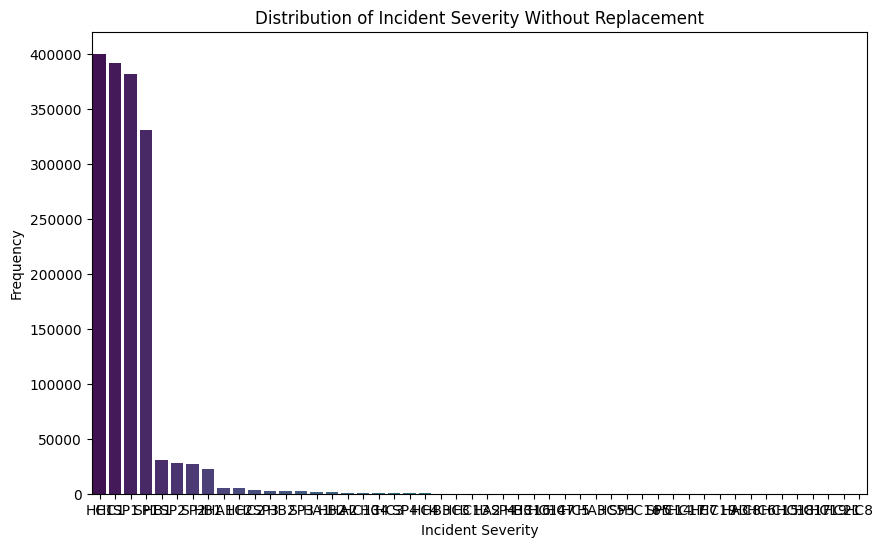

incident_severity
HC1      400452
HC1      391594
SP1      382306
SP1      331478
HB1       30974
SP2       27718
SP2       26860
HB1       22506
HA1        5364
HC2        5056
HC2        3038
SP3        2702
HB2        2098
SP3        2062
HA1        1728
HB2        1456
HA2         424
HC13        386
HC4         344
HC3         282
SP4         280
HC4         226
HB3         186
HC3         166
HC13        166
HA2         146
SP4         124
HB3         100
HC16         80
HC14         68
HC7          68
HC5          66
HA3          64
HC5          36
SP5          34
HC16         28
SP5          18
HC14         18
HC17         16
HC7          14
HC19         10
HA3           8
HC8           8
HC6           8
HC15          4
HC18          4
HC17          4
HC19          2
HC21          2
HC8           2
Name: count, dtype: int64


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming pre_final_data is your DataFrame
class_counts = pre_final_data['incident_severity'].value_counts()

# Plot the distribution of the output classes
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Distribution of Incident Severity Without Replacement')
plt.xlabel('Incident Severity')
plt.ylabel('Frequency')
plt.show()

# Display value counts
print(class_counts)


## **Splitting the data into training, validation and test datasets**

### **Loading the data into the dataframe**

In [21]:
import psycopg2
import pandas as pd
from sklearn.model_selection import train_test_split

# Database connection parameters
db_params = {
    'host': '194.171.191.226',
    'port': '6379',
    'database': 'postgres',
    'user': 'group24',
    'password': 'blockd_2024group24_77'
}

def load_data_from_db(db_params):
    # Connect to the database
    conn = psycopg2.connect(**db_params)
    cursor = conn.cursor()
    
    # Define the query
    query = "SELECT * FROM group24_warehouse.normalised;"
    
    # Execute the query
    cursor.execute(query)
    
    # Fetch all rows
    rows = cursor.fetchall()
    
    # Close cursor and connection
    cursor.close()
    conn.close()
    
    # Convert the rows to DataFrame
    df = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
    
    return df

normalised_df = load_data_from_db(db_params)

### **Splitting the data into their respective sets**

In [22]:
# Assuming 'incident_severity' is the target column and the rest are features
X = normalised_df.drop(columns=['incident_severity'])
y = normalised_df['incident_severity']

# Split the data into training (60%), testing (20%), and validation (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Verify the splits
print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])
print("Validation set size:", X_val.shape[0])


Training set size: 530704
Testing set size: 176902
Validation set size: 176902


### **Address Class Imbalance**
- We will use the following techniques:
1. Random Sampling with Replacement: Implementing manually.
2. Class Weighting: Demonstrating how to use class_weight during model training.

#### **1. Random Sampling with Replacement**

Class distribution after Random Sampling with Replacement:
incident_severity
HC1     262111
SP1     220792
SP2      18182
HB1      15343
HC2       3334
SP3       1440
HA1       1223
HB2        990
HC4        178
HC13       147
HC3        110
HA2         98
SP4         88
HB3         85
HC5         29
HC16        20
HC14        18
HC7         13
SP5         11
HA3          6
HC17         3
HC8          1
Name: count, dtype: int64


/tmp/ipykernel_707742/4213748066.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=resampled_class_counts.index, y=resampled_class_counts.values, palette='viridis')


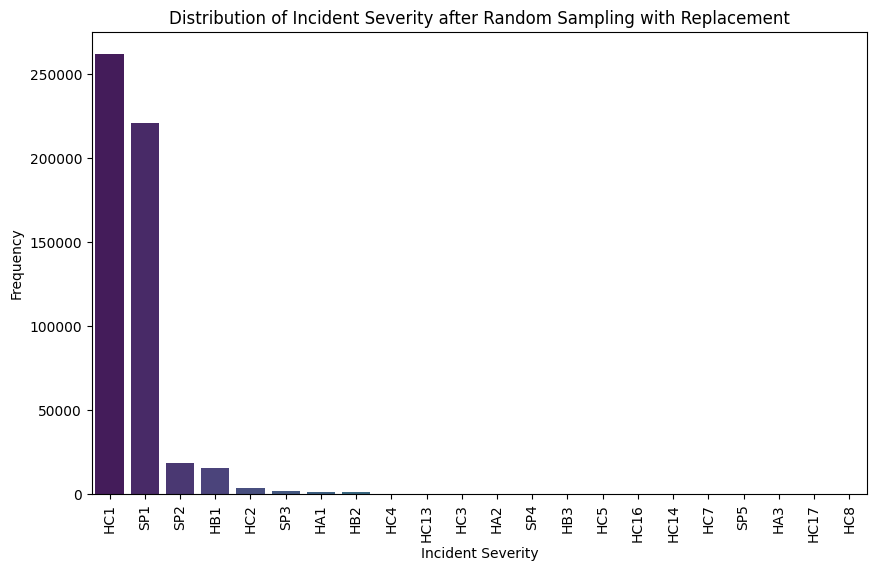

In [23]:
import pandas as pd
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

# Combine X_train and y_train for sampling
train_data = pd.concat([X_train, y_train], axis=1)

# Remove rows with NaN values in 'incident_severity'
train_data = train_data.dropna(subset=['incident_severity'])

# Ensure incident_severity column is of type string to avoid NaN appearing as a result of type issues
train_data['incident_severity'] = train_data['incident_severity'].astype(str)

# Separate the majority and minority classes
incident_severity_mode = train_data['incident_severity'].mode()[0]
majority_class = train_data[train_data['incident_severity'] == incident_severity_mode]
minority_class = train_data[train_data['incident_severity'] != incident_severity_mode]

# Randomly sample with replacement from the majority class to match the number of minority class samples
resampled_majority_class = resample(majority_class, 
                                    replace=True, 
                                    n_samples=len(minority_class), 
                                    random_state=42)

# Combine the resampled majority class with the original minority class
resampled_data = pd.concat([resampled_majority_class, minority_class])

# Remove any NaN values in the combined data again after resampling
resampled_data = resampled_data.dropna(subset=['incident_severity'])

# Check for and remove any remaining NaN values or strings 'NaN'
resampled_data = resampled_data[resampled_data['incident_severity'] != 'NaN']

# Separate features and target
X_resampled = resampled_data.drop(columns=['incident_severity'])
y_resampled = resampled_data['incident_severity']

# Verify the class distribution after random sampling with replacement
resampled_class_counts = y_resampled.value_counts()
print("Class distribution after Random Sampling with Replacement:")
print(resampled_class_counts)

# Plot the distribution of the resampled output classes
plt.figure(figsize=(10, 6))
sns.barplot(x=resampled_class_counts.index, y=resampled_class_counts.values, palette='viridis')
plt.title('Distribution of Incident Severity after Random Sampling with Replacement')
plt.xlabel('Incident Severity')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


### **Saving preprocessing steps for further data to be implemented into the system**

In [24]:
import pandas as pd
import psycopg2
from psycopg2.extras import execute_values
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np

# Define the DataPreprocessor class
class DataPreprocessor:
    def __init__(self, db_params, default_timestamp, landmark_coords, columns_info):
        self.db_params = db_params
        self.default_timestamp = default_timestamp
        self.landmark_coords = landmark_coords
        self.columns_info = columns_info

    def connect_to_db(self):
        """Establish a connection to the database."""
        try:
            conn = psycopg2.connect(**self.db_params)
            return conn
        except Exception as e:
            print(f"Error connecting to the database: {e}")
            return None

    def read_table(self, query):
        """Read a table from the database into a DataFrame."""
        conn = self.connect_to_db()
        if conn is None:
            return pd.DataFrame()
        try:
            df = pd.read_sql_query(query, conn)
            return df
        except Exception as e:
            print(f"Error reading table: {e}")
            return pd.DataFrame()
        finally:
            conn.close()

    def clean_dataframe(self, df, table_name):
        """Clean and preprocess the DataFrame according to the table schema."""
        df = df.copy()
        columns_info = self.columns_info[table_name]
        
        lat_col, lon_col = 'latitude', 'longitude'
        event_start_col = next((col for col, dtype in columns_info if dtype == 'TIMESTAMP'), 'event_start')
        event_end_col = event_start_col  # Default end column same as start if not specified
        
        df[event_start_col] = pd.to_datetime(df[event_start_col], errors='coerce', utc=True).fillna(self.default_timestamp)
        df[event_end_col] = pd.to_datetime(df[event_end_col], errors='coerce', utc=True).fillna(self.default_timestamp)
        
        landmark_latitude, landmark_longitude = self.landmark_coords
        df['distance_to_landmark'] = ((df[lat_col] - landmark_latitude)**2 + (df[lon_col] - landmark_longitude)**2)**0.5
        
        def time_of_day(hour):
            if 5 <= hour < 12:
                return 'Morning'
            elif 12 <= hour < 17:
                return 'Afternoon'
            elif 17 <= hour < 21:
                return 'Evening'
            else:
                return 'Night'
        
        if pd.api.types.is_datetime64_any_dtype(df[event_start_col]):
            df['time_of_day'] = df[event_start_col].dt.hour.apply(time_of_day)
        
        for col, dtype in columns_info:
            if dtype in ['REAL', 'INTEGER', 'BIGINT']:
                df[col] = df[col].fillna(0)
            elif dtype == 'TIMESTAMP':
                df[col] = pd.to_datetime(df[col], errors='coerce', utc=True).fillna(self.default_timestamp)
            else:
                df[col] = df[col].fillna('')
        
        df = df[[col for col, _ in columns_info]]
        return df

    def preprocess_dataframe(self, df, table_name):
        """Preprocess the DataFrame by filling missing values and converting data types."""
        columns_info = self.columns_info[table_name]
        datetime_columns = [col for col, dtype in columns_info if dtype == 'TIMESTAMP']
        
        for col in datetime_columns:
            df[col] = pd.to_datetime(df[col], errors='coerce', utc=True).fillna(self.default_timestamp)
        
        for col, dtype in columns_info:
            if dtype in ['REAL', 'INTEGER', 'BIGINT']:
                df[col] = df[col].fillna(0)
            else:
                df[col] = df[col].fillna('')
        return df

    def insert_data(self, df, insert_query):
        """Insert data into the database."""
        try:
            conn = self.connect_to_db()
            cursor = conn.cursor()
            data_tuples = list(df.itertuples(index=False, name=None))
            execute_values(cursor, insert_query, data_tuples)
            conn.commit()
            table_name = insert_query.split()[2]
            print(f"Data inserted successfully into '{table_name}' table.")
        except Exception as e:
            table_name = insert_query.split()[2]
            print(f"Error inserting data into '{table_name}' table: {e}")
            if conn:
                conn.rollback()
        finally:
            if conn:
                cursor.close()
                conn.close()

    def fetch_and_preprocess_data(self):
        """Fetch and preprocess data from the database."""
        safe_driving_df = self.read_table(safe_driving_query)
        breda_road_df = self.read_table(breda_road_query)
        precipitation_df = self.read_table(precipitation_query)
        temperature_df = self.read_table(temperature_query)
        greenery_df = self.read_table(greenery_query)

        safe_driving_df = self.clean_dataframe(safe_driving_df, 'safe_driving')
        breda_road_df = self.clean_dataframe(breda_road_df, 'breda_road')
        precipitation_df = self.clean_dataframe(precipitation_df, 'precipitation')
        temperature_df = self.clean_dataframe(temperature_df, 'temperature')
        greenery_df = self.clean_dataframe(greenery_df, 'greenery')

        safe_driving_df = self.preprocess_dataframe(safe_driving_df, 'safe_driving')
        breda_road_df = self.preprocess_dataframe(breda_road_df, 'breda_road')
        precipitation_df = self.preprocess_dataframe(precipitation_df, 'precipitation')
        temperature_df = self.preprocess_dataframe(temperature_df, 'temperature')
        greenery_df = self.preprocess_dataframe(greenery_df, 'greenery')

        return safe_driving_df, breda_road_df, precipitation_df, temperature_df, greenery_df

    def join_data(self, conn, join_query):
        """Perform SQL joins on the database."""
        cursor = conn.cursor()
        cursor.execute(join_query)
        result_df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])
        cursor.close()
        return result_df

    def normalize_and_insert_data(self, df, normalize=True, method='minmax'):
        """Normalize and insert consolidated data into the database."""
        conn = self.connect_to_db()
        if conn is None:
            return
        cursor = conn.cursor()
        
        timestamp_cols = ['event_start', 'event_end', 'breda_begintijd', 'breda_eindtijd', 'precip_dtg', 'temp_dtg']
        df[timestamp_cols] = df[timestamp_cols].apply(pd.to_datetime, errors='coerce').fillna(self.default_timestamp)
        
        columns = [
            'event_start', 'event_end', 'duration_seconds', 'latitude', 'longitude', 'speed_kmh', 'end_speed_kmh', 'maxwaarde',
            'category', 'incident_severity', 'is_valid', 'road_manager_type', 'road_number', 'road_name',
            'place_name', 'municipality_name', 'road_manager_name', 'breda_begintijd', 'breda_eindtijd', 'bgt_status', 'plus_status',
            'bgt_functie', 'plus_functie', 'bgt_fysiekvoorkomen', 'plus_fysiekvoorkomen',
            'precip_dtg', 'dr_pws_10', 'dr_regenm_10', 'ww_cor_10', 'ri_pws_10', 'ri_regenm_10', 'temp_dtg', 't_dryb_10', 'tn_10cm_past_6h_10',
            't_dewp_10', 't_wetb_10'
        ]
        
        df_filtered = df[columns].copy()
        
        if normalize:
            # List of columns to apply different scalers
            min_max_cols = ['speed_kmh', 'end_speed_kmh', 'latitude', 'longitude']
            standard_cols = ['duration_seconds', 't_dryb_10']
            robust_cols = ['dr_pws_10', 'maxwaarde']
    
            # Define scalers
            scalers = ColumnTransformer([
                ('min_max', MinMaxScaler(), min_max_cols),
                ('standard', StandardScaler(), standard_cols),
                ('robust', RobustScaler(), robust_cols)
            ])
    
            # Fill NaNs with 0 in numerical columns before scaling
            df_filtered[min_max_cols + standard_cols + robust_cols] = \
                df_filtered[min_max_cols + standard_cols + robust_cols].fillna(0)
    
            # Apply the transformations
            df_scaled = scalers.fit_transform(df_filtered[min_max_cols + standard_cols + robust_cols])
    
            # Create a DataFrame from the scaled data
            df_scaled = pd.DataFrame(df_scaled, columns=min_max_cols + standard_cols + robust_cols)
    
            # Replace the original numerical columns with the normalized columns
            df_filtered[min_max_cols + standard_cols + robust_cols] = df_scaled
    
        insert_query = """
        INSERT INTO group24_warehouse.normalised (
            event_start, event_end, duration_seconds, latitude, longitude, speed_kmh, end_speed_kmh, maxwaarde,
            category, incident_severity, is_valid, road_manager_type, road_number, road_name,
            place_name, municipality_name, road_manager_name, breda_begintijd, breda_eindtijd, bgt_status, plus_status,
            bgt_functie, plus_functie, bgt_fysiekvoorkomen, plus_fysiekvoorkomen,
            precip_dtg, dr_pws_10, dr_regenm_10, ww_cor_10, ri_pws_10, ri_regenm_10, temp_dtg, t_dryb_10, tn_10cm_past_6h_10,
            t_dewp_10, t_wetb_10
        ) VALUES %s
        ON CONFLICT DO NOTHING;
        """
        def get_chunks(df, chunk_size=1000):
            for i in range(0, len(df), chunk_size):
                yield df.iloc[i:i + chunk_size]
        
        for chunk in get_chunks(df_filtered):
            data_tuples = [tuple(x) for x in chunk.to_numpy()]
            execute_values(cursor, insert_query, data_tuples)
            conn.commit()
            print(f"Inserted {len(data_tuples)} rows")
        
        cursor.close()
        conn.close()
        print("Data inserted into normalised table successfully.")

# Define the queries to fetch data
safe_driving_query = """
SELECT DISTINCT eventid, event_start, event_end, duration_seconds, latitude, longitude, speed_kmh, end_speed_kmh,
       maxwaarde, category, incident_severity, is_valid, road_segment_id, road_manager_type, road_number, 
       road_name, place_name, municipality_name, road_manager_name 
FROM data_lake.safe_driving
WHERE is_valid = True;
"""
breda_road_query = """
SELECT DISTINCT _id, objectbegintijd, objecteindtijd, bgt_status, plus_status, bgt_functie, plus_functie,
       bgt_fysiekvoorkomen, plus_fysiekvoorkomen, wegdeeloptalud, relatievehoogteligging 
FROM data_lake.breda_road;
"""
precipitation_query = """
SELECT DISTINCT dtg, latitude, longitude, altitude, dr_pws_10, dr_regenm_10, ww_cor_10, ri_pws_10, ri_regenm_10 
FROM data_lake.precipitation;
"""
temperature_query = """
SELECT DISTINCT dtg, latitude, longitude, altitude, t_dryb_10, tn_10cm_past_6h_10, t_dewp_10, t_wetb_10 
FROM data_lake.temperature;
"""
greenery_query = """
SELECT DISTINCT _id, _key, namespace, lokaalid, objectbegintijd, objecteindtijd, tijdstipregistratie, eindregistratie,
       lv_publicatiedatum, bronhouder, inonderzoek, relatievehoogteligging, bgt_status, plus_status, bgt_type, plus_type 
FROM data_lake.greenery;
"""

# Database connection parameters
db_params = {
    'host': '194.171.191.226',
    'port': '6379',
    'database': 'postgres',
    'user': 'group24',
    'password': 'blockd_2024group24_77'
}


# Define the columns and their data types for each table
columns_info = {
    "safe_driving": [
        ('eventid', 'INTEGER'),
        ('event_start', 'TIMESTAMP'),
        ('event_end', 'TIMESTAMP'),
        ('duration_seconds', 'REAL'),
        ('latitude', 'REAL'),
        ('longitude', 'REAL'),
        ('speed_kmh', 'REAL'),
        ('end_speed_kmh', 'REAL'),
        ('maxwaarde', 'REAL'),
        ('category', 'VARCHAR'),
        ('incident_severity', 'VARCHAR'),
        ('is_valid', 'BOOLEAN'),
        ('road_segment_id', 'INTEGER'),
        ('road_manager_type', 'VARCHAR'),
        ('road_number', 'VARCHAR'),
        ('road_name', 'VARCHAR'),
        ('place_name', 'VARCHAR'),
        ('municipality_name', 'VARCHAR'),
        ('road_manager_name', 'VARCHAR')
    ],
    "breda_road": [
        ('_id', 'BIGINT'),
        ('objectbegintijd', 'TIMESTAMP'),
        ('objecteindtijd', 'TIMESTAMP'),
        ('bgt_status', 'VARCHAR'),
        ('plus_status', 'VARCHAR'),
        ('bgt_functie', 'VARCHAR'),
        ('plus_functie', 'VARCHAR'),
        ('bgt_fysiekvoorkomen', 'VARCHAR'),
        ('plus_fysiekvoorkomen', 'VARCHAR'),
        ('wegdeeloptalud', 'BIGINT'),
        ('relatievehoogteligging', 'BIGINT'),
        ('latitude', 'REAL'),
        ('longitude', 'REAL')
    ],
    "precipitation": [
        ('dtg', 'TIMESTAMP'),
        ('latitude', 'REAL'),
        ('longitude', 'REAL'),
        ('altitude', 'REAL'),
        ('dr_pws_10', 'REAL'),
        ('dr_regenm_10', 'REAL'),
        ('ww_cor_10', 'REAL'),
        ('ri_pws_10', 'REAL'),
        ('ri_regenm_10', 'REAL')
    ],
    "temperature": [
        ('dtg', 'TIMESTAMP'),
        ('latitude', 'REAL'),
        ('longitude', 'REAL'),
        ('altitude', 'REAL'),
        ('t_dryb_10', 'REAL'),
        ('tn_10cm_past_6h_10', 'REAL'),
        ('t_dewp_10', 'REAL'),
        ('t_wetb_10', 'REAL')
    ],
    "greenery": [
        ('_id', 'BIGINT'),
        ('_key', 'VARCHAR'),
        ('namespace', 'VARCHAR'),
        ('lokaalid', 'VARCHAR'),
        ('objectbegintijd', 'TIMESTAMP'),
        ('objecteindtijd', 'TIMESTAMP'),
        ('tijdstipregistratie', 'TIMESTAMP'),
        ('eindregistratie', 'TIMESTAMP'),
        ('lv_publicatiedatum', 'TIMESTAMP'),
        ('bronhouder', 'VARCHAR'),
        ('inonderzoek', 'BIGINT'),
        ('relatievehoogteligging', 'BIGINT'),
        ('bgt_status', 'VARCHAR'),
        ('plus_status', 'VARCHAR'),
        ('bgt_type', 'VARCHAR'),
        ('plus_type', 'VARCHAR'),
        ('latitude', 'REAL'),
        ('longitude', 'REAL')
    ]
}

# Define default timestamp for missing datetime values
default_timestamp = pd.Timestamp('1970-01-01', tz='UTC')

# Define the landmark coordinates for distance calculation
landmark_coords = (51.5890, 4.7745)

# Create an instance of DataPreprocessor
preprocessor = DataPreprocessor(db_params, default_timestamp, landmark_coords, columns_info)

# Fetch and preprocess the data
safe_driving_df, breda_road_df, precipitation_df, temperature_df, greenery_df = preprocessor.fetch_and_preprocess_data()

# Define the insert queries for each table
insert_safe_driving_query = """
INSERT INTO group24_warehouse.safe_driving (
    eventid, event_start, event_end, duration_seconds, latitude, longitude, 
    speed_kmh, end_speed_kmh, maxwaarde, category, incident_severity, is_valid, 
    road_segment_id, road_manager_type, road_number, road_name, place_name, 
    municipality_name, road_manager_name
) VALUES %s
ON CONFLICT (eventid) DO NOTHING;
"""

insert_breda_road_query = """
INSERT INTO group24_warehouse.breda_road (
    _id, objectbegintijd, objecteindtijd, bgt_status, plus_status, 
    bgt_functie, plus_functie, bgt_fysiekvoorkomen, plus_fysiekvoorkomen, 
    wegdeeloptalud, relatievehoogteligging, latitude, longitude
) VALUES %s
ON CONFLICT (_id) DO NOTHING;
"""

insert_precipitation_query = """
INSERT INTO group24_warehouse.precipitation (
    dtg, latitude, longitude, altitude, dr_pws_10, dr_regenm_10, 
    ww_cor_10, ri_pws_10, ri_regenm_10
) VALUES %s
ON CONFLICT (dtg, latitude, longitude) DO NOTHING;
"""

insert_temperature_query = """
INSERT INTO group24_warehouse.temperature (
    dtg, latitude, longitude, altitude, t_dryb_10, tn_10cm_past_6h_10, 
    t_dewp_10, t_wetb_10
) VALUES %s
ON CONFLICT (dtg, latitude, longitude) DO NOTHING;
"""

insert_greenery_query = """
INSERT INTO group24_warehouse.greenery (
    _id, _key, namespace, lokaalid, objectbegintijd, objecteindtijd, 
    tijdstipregistratie, eindregistratie, lv_publicatiedatum, bronhouder, 
    inonderzoek, relatievehoogteligging, bgt_status, plus_status, 
    bgt_type, plus_type, latitude, longitude
) VALUES %s
ON CONFLICT (_id) DO NOTHING;
"""

# Insert data into respective tables
preprocessor.insert_data(safe_driving_df, insert_safe_driving_query)
preprocessor.insert_data(breda_road_df, insert_breda_road_query)
preprocessor.insert_data(precipitation_df, insert_precipitation_query)
preprocessor.insert_data(temperature_df, insert_temperature_query)
preprocessor.insert_data(greenery_df, insert_greenery_query)

# Define the join queries
join_safe_driving_breda_road_query = """
SELECT sd.eventid, sd.event_start, sd.event_end, sd.duration_seconds, sd.latitude, sd.longitude,
       sd.speed_kmh, sd.end_speed_kmh, sd.maxwaarde, sd.category, sd.incident_severity, sd.is_valid,
       sd.road_segment_id, sd.road_manager_type, sd.road_number, sd.road_name, sd.place_name,
       sd.municipality_name, sd.road_manager_name, br._id AS breda_id, br.objectbegintijd, br.objecteindtijd,
       br.bgt_status, br.plus_status, br.bgt_functie, br.plus_functie, br.bgt_fysiekvoorkomen,
       br.plus_fysiekvoorkomen, br.wegdeeloptalud, br.relatievehoogteligging
FROM group24_warehouse.safe_driving sd
LEFT JOIN group24_warehouse.breda_road br
ON sd.event_start = br.objectbegintijd;
"""

join_safe_driving_precipitation_query = """
SELECT sd.eventid, sd.event_start, sd.event_end, sd.duration_seconds, sd.latitude, sd.longitude,
       sd.speed_kmh, sd.end_speed_kmh, sd.maxwaarde, sd.category, sd.incident_severity, sd.is_valid,
       sd.road_segment_id, sd.road_manager_type, sd.road_number, sd.road_name, sd.place_name,
       sd.municipality_name, sd.road_manager_name, pc.dtg AS precip_dtg, pc.latitude AS precip_latitude,
       pc.longitude AS precip_longitude, pc.altitude AS precip_altitude, pc.dr_pws_10, pc.dr_regenm_10,
       pc.ww_cor_10, pc.ri_pws_10, pc.ri_regenm_10
FROM group24_warehouse.safe_driving sd
LEFT JOIN group24_warehouse.precipitation pc
ON sd.event_start = pc.dtg;
"""

join_temperature_precipitation_query = """
SELECT tp.dtg AS temp_dtg, tp.latitude AS temp_latitude, tp.longitude AS temp_longitude, tp.altitude AS temp_altitude,
       tp.t_dryb_10, tp.tn_10cm_past_6h_10, tp.t_dewp_10, tp.t_wetb_10, pc.dtg AS precip_dtg, pc.latitude AS precip_latitude,
       pc.longitude AS precip_longitude, pc.altitude AS precip_altitude, pc.dr_pws_10, pc.dr_regenm_10, pc.ww_cor_10,
       pc.ri_pws_10, pc.ri_regenm_10
FROM group24_warehouse.temperature tp
LEFT JOIN group24_warehouse.precipitation pc
ON tp.dtg = pc.dtg;
"""

# Connect to the database and perform join operations
conn = preprocessor.connect_to_db()
if conn is not None:
    print("Joining safe_driving and breda_road")
    safe_driving_breda_road = preprocessor.join_data(conn, join_safe_driving_breda_road_query)
    
    print("Joining safe_driving and precipitation")
    safe_driving_precipitation = preprocessor.join_data(conn, join_safe_driving_precipitation_query)
    
    print("Joining temperature and precipitation")
    temperature_precipitation = preprocessor.join_data(conn, join_temperature_precipitation_query)
    
    conn.close()
    
    # Vertically concatenate the DataFrames
    pre_final_data = pd.concat([safe_driving_breda_road, safe_driving_precipitation, temperature_precipitation], ignore_index=True)
    
    print(pre_final_data.head())

# Normalize and insert the consolidated data into the normalised table
preprocessor.normalize_and_insert_data(pre_final_data, normalize=True, method='standard')


/tmp/ipykernel_707742/4036262281.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


KeyboardInterrupt: 